### Prerequisite Packages

In [1]:
import os
import sys
import numpy as np
import pandas as pd

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.nn.init as init
import torch.optim as optim
import matplotlib.pyplot as plt
import seaborn as sns
from torch.utils.data import DataLoader, Dataset, WeightedRandomSampler
from torcheval.metrics import BinaryAccuracy, BinaryPrecision, BinaryRecall, BinaryF1Score
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import confusion_matrix
from tqdm import tqdm

sys.path.append('../')

from modules.classifier import DenseLayer, BCELoss, CustomLoss, BCEWithLogits, FocalLoss
from modules.dataloader import load_npy_files
from modules.linear_transformation import LinearTransformations

### Model and Hyperparameter Configurations

In [2]:
# Ensure reproducibility
def set_seed(seed=42):
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

In [3]:
# Define possible configurations for audio feature directories
audio_feature_paths = {
    'logmel': '../misc/audio_features/logmel',
    'mfcc': '../misc/audio_features/mfcc'
}

# Function to get the audio feature path based on the selected configuration
def get_audio_feature_path(config_name):
    if config_name in audio_feature_paths:
        return audio_feature_paths[config_name]
    else:
        raise ValueError(f"Configuration '{config_name}' not found. Available options: logmel, mfcc.")


In [4]:
### Device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Device: {device}")

set_seed(42)  # Set global seed at the start

### Audio Feature selection: 'logmel' or 'mfcc'
selected_audio_feature = 'logmel'
audio_features_dir = get_audio_feature_path(selected_audio_feature)

#### Data Configuration: 8 16 32 64 128
train_batch_size = 32   # Set the batch size for training data
val_batch_size = 16     # Set the batch size for validation data
test_batch_size= 16     # Set the batch size for testing data

### Filter outliers in video features
lower_bound=35
upper_bound=197

### Hyperparameters
threshold = 0.5              # for predictions
learning_rate = 1e-4       # For optimizer
num_epochs = 10              # for model training
cl_dropout_rate = 0.4        # for FinalClassifier

### Classifier Configuration
isBCELoss = True                          # !!! SET ACCORDINGLY !!!
criterion = BCELoss()
# criterion = BCEWithLogits().to(device)
# criterion = CustomLoss(pos_weight=2.94)
# criterion = FocalLoss(alpha=0.25, gamma=2, pos_weight=0.34)

# !!! Choose Classifier !!! False = Dense Layer, True = Final Classifier
isFinalClassifier = True

# Define the dimensions for GMU
text_dim = 1024 
audio_dim = 768 
video_dim = 768  
output_dim = 768 

## For cross validation
num_folds = 5          # Set the number of folds for cross-validation
num_epochs_cv = 10     # Set the number of epochs for cross-validation


Device: cuda


### Dataset Class

In [5]:
class MultimodalDataset(Dataset):
    def __init__(self, id_label_df, text_features, audio_features, video_features):
        self.id_label_df = id_label_df
        
        # Convert feature lists to dictionaries for fast lookup
        self.text_features = {os.path.basename(file).split('.')[0]: tensor for file, tensor in text_features}
        self.audio_features = {os.path.basename(file).split('_')[1].split('.')[0]: tensor for file, tensor in audio_features}
        self.video_features = {os.path.basename(file).split('_')[0]: tensor for file, tensor in video_features}
        
        # List to store missing files
        self.missing_files = []
        
        # Filter out entries with missing files
        self.valid_files = self._filter_valid_files()

    def _filter_valid_files(self):
        valid_indices = []
        missing_files = []

        for idx in range(len(self.id_label_df)):
            imdbid = self.id_label_df.iloc[idx]['IMDBid']

            # Check if the IMDBid exists in each modality's features
            if imdbid in self.text_features and imdbid in self.audio_features and imdbid in self.video_features:
                valid_indices.append(idx)
            else:
                missing_files.append({'IMDBid': imdbid})

        # Filter id_label_df to only include valid rows
        self.id_label_df = self.id_label_df.iloc[valid_indices].reset_index(drop=True)
        self.missing_files = missing_files
        
        # Update valid_indices to reflect the new indices after resetting
        valid_indices = list(range(len(self.id_label_df)))

        # Return valid indices
        return valid_indices

    def __len__(self):
        return len(self.valid_files)

    def __getitem__(self, idx):
        # Get the original index from the filtered valid files
        original_idx = self.valid_files[idx]
        imdbid = self.id_label_df.iloc[original_idx]['IMDBid']
        label = self.id_label_df.iloc[original_idx]['Label']
        
        # Retrieve data from the loaded features
        text_data = self.text_features.get(imdbid, torch.zeros((1024,)))
        audio_data = self.audio_features.get(imdbid, torch.zeros((1, 197, 768)))
        video_data = self.video_features.get(imdbid, torch.zeros((95, 768)))
        
        # Define label mapping and ensure binary values
        label_map = {'red': 1.0, 'green': 0.0}
        
        try:
            label_data = torch.tensor([label_map[label]], dtype=torch.float32)
        except KeyError as e:
            print(f"Error: Label '{e}' not found in label_map.")
            raise

        return imdbid, text_data, audio_data, video_data, label_data


In [6]:
def collate_fn(batch):
    # Unpack batch elements
    imdbids, text_data, audio_data, video_data, label_data = zip(*batch)

    # Convert lists to tensors
    text_data = torch.stack(text_data)
    audio_data = torch.stack(audio_data)

    # Padding for video data
    # Determine maximum length of video sequences in the batch
    video_lengths = [v.size(0) for v in video_data]
    max_length = max(video_lengths)

    # Pad video sequences to the maximum length
    video_data_padded = torch.stack([
        F.pad(v, (0, 0, 0, max_length - v.size(0)), "constant", 0)
        for v in video_data
    ])

    # Convert labels to tensor and ensure the shape [batch_size, 1]
    label_data = torch.stack(label_data)  # Convert list of tensors to a single tensor

    return imdbids, text_data, audio_data, video_data_padded, label_data


In [7]:
def filter_video_features(video_features, lower_bound=lower_bound, upper_bound=upper_bound):
    # Assuming video_features is a list of tuples where the second element is the numpy array
    filtered_video_features = [v for v in video_features if lower_bound <= v[1].shape[0] <= upper_bound]
    return filtered_video_features


### Data Loading

In [8]:
# Load the labels DataFrame
id_label_df = pd.read_excel('../misc/MM-Trailer_dataset.xlsx')

# Define the directories
text_features_dir = '../misc/text_features'
audio_features_dir = audio_features_dir
video_features_dir = '../misc/video_features'

# Load the feature vectors from each directory
text_features = load_npy_files(text_features_dir)
audio_features = load_npy_files(audio_features_dir)
video_features = load_npy_files(video_features_dir)

video_features = filter_video_features(video_features)

print(f"Number of text feature vectors loaded: {len(text_features)}")
print(f"Number of audio feature vectors loaded: {len(audio_features)}")
print(f"Number of video feature vectors loaded: {len(video_features)}")

# Drop unnecessary columns
id_label_df = id_label_df.drop(columns=['Movie Title', 'URL'])

full_dataset = MultimodalDataset(id_label_df, text_features, audio_features, video_features)

# perform train-test split on the filtered DataFrame
train_df, val_test_df = train_test_split(
    full_dataset.id_label_df, test_size=0.3, random_state=42, stratify=full_dataset.id_label_df['Label'])

# Further splitting remaining set into validation and test sets
val_df, test_df = train_test_split(
    val_test_df, test_size=0.5, random_state=42, stratify=val_test_df['Label'])

print("train_df shape:", train_df.shape)
print("val_df shape:", val_df.shape)
print("test_df shape:", test_df.shape)

print("Train label distribution:", train_df['Label'].value_counts())
print("Validation label distribution:", val_df['Label'].value_counts())
print("Test label distribution:", test_df['Label'].value_counts())

print("-" * 40)

# create datasets based on these splits
train_dataset = MultimodalDataset(train_df, text_features, audio_features, video_features)
val_dataset = MultimodalDataset(val_df, text_features, audio_features, video_features)
test_dataset = MultimodalDataset(test_df, text_features, audio_features, video_features)

# Create DataLoaders
train_dataloader = DataLoader(train_dataset, batch_size=train_batch_size, shuffle=True, num_workers=0, collate_fn=collate_fn, generator=torch.Generator().manual_seed(42))
val_dataloader = DataLoader(val_dataset, batch_size=val_batch_size, shuffle=True, num_workers=0, collate_fn=collate_fn, generator=torch.Generator().manual_seed(42))
test_dataloader = DataLoader(test_dataset, batch_size=test_batch_size, shuffle=False, num_workers=0, collate_fn=collate_fn, generator=torch.Generator().manual_seed(42))

# Function to calculate and print the size of each DataLoader
def print_dataloader_sizes(dataloader, name):
    total_samples = len(dataloader.dataset)  # Get the size of the dataset
    num_batches = len(dataloader)  # Get the number of batches
    print(f"{name} DataLoader: Total Samples = {total_samples}, Number of Batches = {num_batches}")

# Print sizes of each DataLoader
print_dataloader_sizes(train_dataloader, "Train")
print_dataloader_sizes(val_dataloader, "Validation")
print_dataloader_sizes(test_dataloader, "Test")



Number of text feature vectors loaded: 1353
Number of audio feature vectors loaded: 1353
Number of video feature vectors loaded: 1325
train_df shape: (927, 2)
val_df shape: (199, 2)
test_df shape: (199, 2)
Train label distribution: Label
green    693
red      234
Name: count, dtype: int64
Validation label distribution: Label
green    149
red       50
Name: count, dtype: int64
Test label distribution: Label
green    149
red       50
Name: count, dtype: int64
----------------------------------------
Train DataLoader: Total Samples = 927, Number of Batches = 29
Validation DataLoader: Total Samples = 199, Number of Batches = 13
Test DataLoader: Total Samples = 199, Number of Batches = 13


### GMU Class

In [9]:
# Class for Gated Multimodal Unit of Arevalo et al. (2017)
class GatedMultimodalUnit(torch.nn.Module):
    def __init__(self, text_dim, audio_dim, video_dim, output_dim):
        super(GatedMultimodalUnit, self).__init__()
        
        # Linear transformation for text
        self.text_linear = LinearTransformations(text_dim, output_dim)
        
        # Convolutional layers for audio and video features
        self.audio_conv = nn.Conv1d(audio_dim, output_dim, kernel_size=1)
        self.video_conv = nn.Conv1d(video_dim, output_dim, kernel_size=1)
        
        self.output_dim = output_dim 
        
        # Activation functions
        self.activation = nn.Tanh()
        self.gate_activation = nn.Sigmoid()
        
        # Weight matrices for each modality
        self.W1 = nn.Parameter(torch.Tensor(output_dim, output_dim))
        self.W2 = nn.Parameter(torch.Tensor(output_dim, output_dim))
        self.W3 = nn.Parameter(torch.Tensor(output_dim, output_dim))
        
        # Gating matrices
        self.Y1 = nn.Parameter(torch.Tensor(output_dim, output_dim))
        self.Y2 = nn.Parameter(torch.Tensor(output_dim, output_dim))
        self.Y3 = nn.Parameter(torch.Tensor(output_dim, output_dim))
        
        # Initialize weights
        self._initialize_weights()
        
    def _initialize_weights(self):
        
        # Initialize weight matrices
        init.xavier_uniform_(self.W1)
        init.xavier_uniform_(self.W2)
        init.xavier_uniform_(self.W3)
        
        # Initialize gating matrices
        init.xavier_uniform_(self.Y1)
        init.xavier_uniform_(self.Y2)
        init.xavier_uniform_(self.Y3)
        
        
    def forward(self, text_features, audio_features, video_features):

        # Process text features to match shape
        x_t = self.text_linear(text_features)              # Shape: [batch_size, output_dim]

        # Process audio features to match shape
        audio_features = audio_features.squeeze(1).permute(0, 2, 1)               # Shape: [batch_size, audio_dim, sequence_length] 
        x_a = self.audio_conv(audio_features).mean(dim=-1)              # Shape: [batch_size, output_dim]

        # Process video features to match shape
        video_features = video_features.permute(0, 2, 1)   # Shape: [batch_size, video_dim, sequence_length]
        x_v = self.video_conv(video_features).mean(dim=-1)              # Shape: [batch_size, output_dim]
 
        h1 = self.activation(torch.matmul(x_t, self.W1))        # Shape: [batch_size, output_dim]
        h2 = self.activation(torch.matmul(x_a, self.W2))        # Shape: [batch_size, output_dim]
        h3 = self.activation(torch.matmul(x_v, self.W3))        # Shape: [batch_size, output_dim]
        
        # Compute modality-specific gating weights
        z1 = self.gate_activation(torch.matmul(x_t, self.Y1))  # Shape: [batch_size, output_dim]
        z2 = self.gate_activation(torch.matmul(x_a, self.Y2))  # Shape: [batch_size, output_dim]
        z3 = self.gate_activation(torch.matmul(x_v, self.Y3))  # Shape: [batch_size, output_dim]
        
        # Calculate final output
        h = z1 * h1 + z2 * h2 + z3 * h3         

        return h


### Classifier

In [10]:
class FinalClassifier(nn.Module):
    def __init__(self, input_size, dropout_rate=0.5):
        super(FinalClassifier, self).__init__()
        self.isBCELoss = isBCELoss

        self.fc1 = nn.Linear(input_size, 256)
        self.fc2 = nn.Linear(256, 128)
        
        self.dropout = nn.Dropout(dropout_rate)
        self.dense = nn.Linear(128, 1)
        
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        
        x = self.fc2(x)
        x = self.relu(x)
        x = self.dropout(x)

        x = self.dense(x)
        if self.isBCELoss:
            x = self.sigmoid(x)
        return x

### Model Training Functions

In [11]:
def get_optimizer(parameters, lr=learning_rate):
    return optim.Adam(parameters, lr=lr)

In [12]:
def train_model(
    model, 
    dense_layer, 
    dataloader, 
    criterion, 
    optimizer, 
    device, 
    output_dir='results/gmu/', 
    output_filename='train_predictions.csv',
):
    model.train()
    dense_layer.train()
    total_loss = 0
    
    os.makedirs(output_dir, exist_ok=True)
    
    # Initialize metrics
    precision_metric = BinaryPrecision().to(device)
    recall_metric = BinaryRecall().to(device)
    f1_metric = BinaryF1Score().to(device)
    accuracy_metric = BinaryAccuracy().to(device)
    
    # Reset metrics at the start of training
    precision_metric.reset()
    recall_metric.reset()
    f1_metric.reset()
    accuracy_metric.reset()
    
    results = []
    
    for imdbids, text_features, audio_features, video_features, targets in dataloader:
        # Move all tensors to the same device as the model and criterion
        text_features = text_features.to(device)
        audio_features = audio_features.to(device)
        video_features = video_features.to(device)
        targets = targets.view(-1).to(device)
        
        # Forward pass through GMU
        outputs = model(text_features, audio_features, video_features)

        # Forward pass through dense layer
        predictions = dense_layer(outputs).view(-1)
        
        # Compute loss
        loss = criterion(predictions, targets)
        total_loss += loss.item()
        
        
        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()


        # # Apply sigmoid if not using BCELoss
        if not isBCELoss:
            predictions = torch.sigmoid(predictions)
        
        # Get binary predictions
        binary_preds = (predictions >= threshold).float()
        
        # Store results
        for i in range(len(imdbids)):
            results.append({
                'IMDBid': imdbids[i],
                'Raw Prediction': predictions[i].item(),
                'Binary Prediction': binary_preds[i].item(),
                'Target': targets[i].item()
            })
        
        # Update metrics
        precision_metric.update(binary_preds.long(), targets.long())
        recall_metric.update(binary_preds.long(), targets.long())
        f1_metric.update(binary_preds.long(), targets.long())
        accuracy_metric.update(binary_preds.long(), targets.long())
        

    # Compute metrics
    train_precision = precision_metric.compute().item()
    train_recall = recall_metric.compute().item()
    train_f1_score = f1_metric.compute().item()
    train_accuracy = accuracy_metric.compute().item()
    
    train_average_loss = total_loss / len(dataloader)
    
    # Save results
    results_df = pd.DataFrame(results)
    output_filepath = os.path.join(output_dir, output_filename)
    results_df.to_csv(output_filepath, index=False)
    
    return train_average_loss, train_accuracy, train_precision, train_recall, train_f1_score

In [13]:
def evaluate_model(
    model, 
    dense_layer, 
    dataloader, 
    criterion, 
    device,
    output_dir='results/gmu/', 
    output_filename='val_predictions.csv',
):
    model.eval()
    dense_layer.eval()
    total_loss = 0
    
    os.makedirs(output_dir, exist_ok=True)
    
    # Initialize metrics
    precision_metric = BinaryPrecision().to(device)
    recall_metric = BinaryRecall().to(device)
    f1_metric = BinaryF1Score().to(device)
    accuracy_metric = BinaryAccuracy().to(device)
    
    # Reset metrics at the start of training
    precision_metric.reset()
    recall_metric.reset()
    f1_metric.reset()
    accuracy_metric.reset()
    
    results = []
    all_predictions = []
    all_targets = []
    
    with torch.no_grad():
        for imdbids, text_features, audio_features, video_features, targets in dataloader:
            text_features, audio_features, video_features, targets = (
                text_features.to(device),
                audio_features.to(device),
                video_features.to(device),
                targets.view(-1).to(device)
            )
            

            # Forward passes
            outputs = model(text_features, audio_features, video_features)
            outputs = outputs.view(outputs.size(0), -1)
            
            predictions = dense_layer(outputs).view(-1)
            
            # Compute loss
            loss = criterion(predictions, targets)
            total_loss += loss.item()
            
            # # Apply sigmoid if not using BCELoss
            if not isBCELoss:
                predictions = torch.sigmoid(predictions)
            
            # Get binary predictions
            binary_preds = (predictions >= threshold).float()
            
            # Store predictions and targets for confusion matrix
            all_predictions.extend(predictions.cpu().numpy())
            all_targets.extend(targets.cpu().numpy())
            
            # Store results
            for i in range(len(imdbids)):
                results.append({
                    'IMDBid': imdbids[i],
                    'Raw Prediction': predictions[i].item(),
                    'Binary Prediction': binary_preds[i].item(),
                    'Target': targets[i].item()
                })
            
            # Update metrics
            precision_metric.update(binary_preds.long(), targets.long())
            recall_metric.update(binary_preds.long(), targets.long())
            f1_metric.update(binary_preds.long(), targets.long())
            accuracy_metric.update(binary_preds.long(), targets.long())
    
    # Compute metrics
    val_precision = precision_metric.compute().item()
    val_recall = recall_metric.compute().item()
    val_f1_score = f1_metric.compute().item()
    val_accuracy = accuracy_metric.compute().item()
    
    val_average_loss = total_loss / len(dataloader)
    
    # Calculate confusion matrix
    val_conf_matrix = confusion_matrix(all_targets, np.round(all_predictions))
    
    # Save results
    results_df = pd.DataFrame(results)
    output_filepath = os.path.join(output_dir, output_filename)
    results_df.to_csv(output_filepath, index=False)
    
    return val_average_loss, val_accuracy, val_precision, val_recall, val_f1_score, val_conf_matrix

In [14]:
def test_model(
    model, 
    dense_layer, 
    dataloader, 
    criterion, 
    device,
    output_dir='results/test/', 
    output_filename='test_predictions.csv',
):

    model.eval()
    dense_layer.eval()
    total_loss = 0

    os.makedirs(output_dir, exist_ok=True)

    # Initialize metrics for binary classification
    precision_metric = BinaryPrecision().to(device)
    recall_metric = BinaryRecall().to(device)
    f1_metric = BinaryF1Score().to(device)
    accuracy_metric = BinaryAccuracy().to(device) 
    
    # Reset metrics at the start of testing
    precision_metric.reset()
    recall_metric.reset()
    f1_metric.reset()
    accuracy_metric.reset()

    # List to collect results for CSV
    results = []
    all_targets = []
    all_predictions = []

    with torch.no_grad():
        for imdbids, text_features, audio_features, video_features, targets in dataloader:
            text_features, audio_features, video_features, targets = (
                text_features.to(device),
                audio_features.to(device),
                video_features.to(device),
                targets.to(device).view(-1)
            )
            
            # Pass inputs through GMU model
            outputs = model(text_features, audio_features, video_features)
            outputs = outputs.view(outputs.size(0), -1)  # Shape will be [batch_size, 153600]
            
            # Pass the GMU outputs through the dense layer to get final predictions
            predictions = dense_layer(outputs).view(-1)
            
            
            # Compute loss
            loss = criterion(predictions, targets)
            total_loss += loss.item()

            # # Apply sigmoid if BCELoss is not used
            if not isBCELoss:
                predictions = torch.sigmoid(predictions)

            # Apply threshold to get binary predictions
            binary_preds = (predictions >= threshold).float()
            
            # Store predictions and targets for confusion matrix
            all_predictions.extend(predictions.cpu().numpy())
            all_targets.extend(targets.cpu().numpy())
            
            # Store results
            for i in range(len(imdbids)):
                results.append({
                    'IMDBid': imdbids[i],
                    'Raw Prediction': predictions[i].item(),
                    'Binary Prediction': binary_preds[i].item(),
                    'Target': targets[i].item()
                })
            
            # Update metrics
            precision_metric.update(binary_preds.long(), targets.long())
            recall_metric.update(binary_preds.long(), targets.long())
            f1_metric.update(binary_preds.long(), targets.long())
            accuracy_metric.update(binary_preds.long(), targets.long())
            

    # Compute average precision, recall, F1 score, and accuracy
    test_precision = precision_metric.compute().item()
    test_recall = recall_metric.compute().item()
    test_f1_score = f1_metric.compute().item()
    test_accuracy = accuracy_metric.compute().item() 

    test_average_loss = total_loss / len(dataloader)

    # Calculate confusion matrix
    test_conf_matrix = confusion_matrix(all_targets, np.round(all_predictions))

    # Create DataFrame and save to CSV
    results_df = pd.DataFrame(results)
    output_filepath = os.path.join(output_dir, output_filename)
    results_df.to_csv(output_filepath, index=False, header=True)


    return test_average_loss, test_accuracy, test_precision, test_recall, test_f1_score, test_conf_matrix


### Model Training

In [15]:
def plot_confusion_matrix(conf_matrix, class_names=['Negative', 'Positive']):
    plt.figure(figsize=(6, 5))
    sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", cbar=False,
                xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title('Confusion Matrix')
    plt.show()

In [16]:
# Function to plot training and validation loss
def plot_losses(train_losses, val_losses):
    plt.figure(figsize=(10, 5))
    plt.plot(train_losses, label='Training Loss', color='blue', marker='o')
    plt.plot(val_losses, label='Validation Loss', color='orange', marker='x')
    plt.title('Training and Validation Loss over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid()
    plt.show()

In [17]:
if __name__ == "__main__":
    torch.manual_seed(42)
    
    # Set device configuration
    if device is None:
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Device: {device}")

    # Initialize the SMCA model A
    model = GatedMultimodalUnit(text_dim=text_dim, audio_dim=audio_dim, video_dim=video_dim, output_dim=output_dim).to(device)

    # Own DenseLayer or FinalClassifier
    if isFinalClassifier:
        dense_layer = FinalClassifier(output_dim).to(device) 
    else:
        dense_layer = DenseLayer(output_dim).to(device)

    optimizer = get_optimizer(list(model.parameters()) + list(dense_layer.parameters()), learning_rate)
    
    # Lists to store the training and validation losses
    train_losses = []
    val_losses = []

    for epoch in range(num_epochs):
        print("-" * 40)
        print(f"Epoch {epoch + 1}/{num_epochs}")

        # Ensure you have a dataloader that yields inputs and targets
        train_average_loss, train_accuracy, train_precision, train_recall, train_f1_score = train_model(model=model, dense_layer=dense_layer, dataloader=train_dataloader, criterion=criterion, optimizer=optimizer, device=device)
        train_losses.append(train_average_loss)  # Store training loss

        print("-" * 20, "Train", "-" * 20)
        print(f"Train Accuracy: {train_accuracy:.4f}")
        print(f"Train Precision: {train_precision:.4f}")
        print(f"Train Recall: {train_recall:.4f}")
        print(f"Train F1 Score: {train_f1_score:.4f}")
        print(f"Train Loss: {train_average_loss:.4f}")
    
        
        for name, param in model.named_parameters():
            if param.grad is None:
                print("After train: model:", "No gradient for:", name)
        
        for name, param in dense_layer.named_parameters():
            if param.grad is None:
                print("After train: classifier:", "No gradient for:", name)

        # Validate step
        val_average_loss, val_accuracy, val_precision, val_recall, val_f1_score, val_conf_matrix = evaluate_model(model=model, dense_layer=dense_layer, dataloader=val_dataloader, criterion=criterion, device=device)
        val_losses.append(val_average_loss)  # Store validation loss
        
        print("-" * 20, "Eval", "-" * 20)
        print(f"Eval Accuracy: {val_accuracy:.4f}")
        print(f"Eval Precision: {val_precision:.4f}")
        print(f"Eval Recall: {val_recall:.4f}")
        print(f"Eval F1 Score: {val_f1_score:.4f}")
        print(f"Eval Loss: {val_average_loss:.4f}")
        

    # Testing the model
    print("-" * 40)
    print("Testing the model on the test set...")
    test_average_loss, test_accuracy, test_precision, test_recall, test_f1_score, test_conf_matrix = test_model(model=model, dense_layer=dense_layer, dataloader=test_dataloader, criterion=criterion, device=device)
    
    print("-" * 20, "Test", "-" * 20)
    print(f"Test Accuracy: {test_accuracy:.4f}")
    print(f"Test Precision: {test_precision:.4f}")
    print(f"Test Recall: {test_recall:.4f}")
    print(f"Test F1 Score: {test_f1_score:.4f}")
    print(f"Test Loss: {test_average_loss:.4f}")
    
    # Summary of metrics
    metrics_summary = {
        "Train Accuracy": [train_accuracy],
        "Validation Accuracy": [val_accuracy],
        "Test Accuracy": [test_accuracy],
        "Train Precision": [train_precision],
        "Validation Precision": [val_precision],
        "Test Precision": [test_precision],
        "Train Recall": [train_recall],
        "Validation Recall": [val_recall],
        "Test Recall": [test_recall],
        "Train F1 Score": [train_f1_score],
        "Validation F1 Score": [val_f1_score],
        "Test F1 Score": [test_f1_score],
        "Train Loss": [train_average_loss],
        "Validation Loss": [val_average_loss],
        "Test Loss": [test_average_loss]
    }
    
    # Create DataFrame
    metrics_df = pd.DataFrame(metrics_summary)

Device: cuda
----------------------------------------
Epoch 1/10
-------------------- Train --------------------
Train Accuracy: 0.7346
Train Precision: 0.2273
Train Recall: 0.0214
Train F1 Score: 0.0391
Train Loss: 0.5976
-------------------- Eval --------------------
Eval Accuracy: 0.7487
Eval Precision: 0.0000
Eval Recall: 0.0000
Eval F1 Score: 0.0000
Eval Loss: 0.5561
----------------------------------------
Epoch 2/10
-------------------- Train --------------------
Train Accuracy: 0.7476
Train Precision: 0.0000
Train Recall: 0.0000
Train F1 Score: 0.0000
Train Loss: 0.5415
-------------------- Eval --------------------
Eval Accuracy: 0.7487
Eval Precision: 0.0000
Eval Recall: 0.0000
Eval F1 Score: 0.0000
Eval Loss: 0.5146
----------------------------------------
Epoch 3/10
-------------------- Train --------------------
Train Accuracy: 0.7540
Train Precision: 1.0000
Train Recall: 0.0256
Train F1 Score: 0.0500
Train Loss: 0.4816
-------------------- Eval --------------------
Eval A

### Results Monitoring

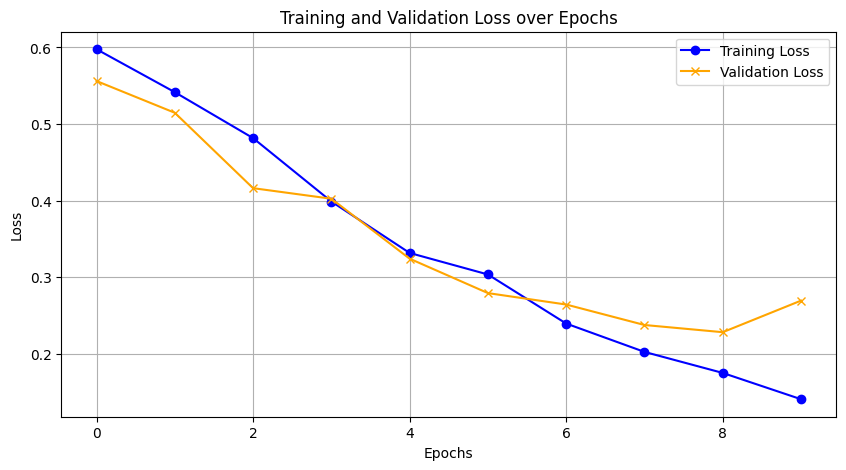

In [18]:
plot_losses(train_losses, val_losses)

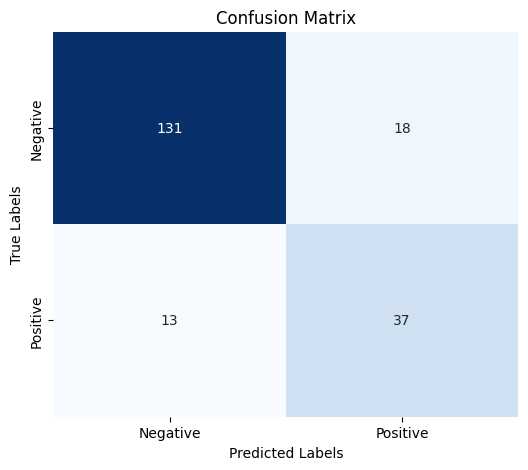

In [19]:
plot_confusion_matrix(test_conf_matrix)

In [20]:
# Display the table
metrics_df

,Train Accuracy,Validation Accuracy,Test Accuracy,Train Precision,Validation Precision,Test Precision,Train Recall,Validation Recall,Test Recall,Train F1 Score,Validation F1 Score,Test F1 Score,Train Loss,Validation Loss,Test Loss
0,0.957929,0.879397,0.844221,0.945205,0.716667,0.672727,0.884615,0.86,0.74,0.913907,0.781818,0.704762,0.140512,0.269312,0.389864


### Cross-Validation

In [21]:
def plot_average_loss_curves(train_losses_folds, val_losses_folds):
    # Transpose folds to calculate averages per epoch
    num_epochs = len(train_losses_folds[0])
    avg_train_losses = [np.mean([fold[epoch] for fold in train_losses_folds]) for epoch in range(num_epochs)]
    avg_val_losses = [np.mean([fold[epoch] for fold in val_losses_folds]) for epoch in range(num_epochs)]

    epochs = range(1, num_epochs + 1)

    plt.figure(figsize=(10, 6))
    plt.plot(epochs, avg_train_losses, label='Average Training Loss', color='blue', marker='o')
    plt.plot(epochs, avg_val_losses, label='Average Validation Loss', color='orange', marker='o')
    
    plt.title('Average Training and Validation Loss Across Folds')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.show()

In [22]:
def print_cv_dataloader(dataloader, name="Dataloader"):
    total_samples = len(dataloader.sampler)
    num_batches = len(dataloader)
    print(f"{name}: Total Samples = {total_samples}, Number of Batches = {num_batches}")

In [23]:
def cross_validate_model(
    dataset, 
    model_class, 
    dense_layer_class, 
    num_folds, 
    num_epochs,
    text_dim,
    audio_dim,
    video_dim,
    output_dim,
    criterion,
    learning_rate,
    train_batch_size,
    val_batch_size,
    output_file,
    device=None
):
    # Set device configuration
    if device is None:
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Device: {device}")
    
    set_seed(42)  # Set global seed at the start
    
    # Initialize the KFold splitter
    kf = KFold(n_splits=num_folds, shuffle=True, random_state=42)

    # lists to store metrics for each fold
    fold_losses = []
    fold_accuracies = []
    fold_precisions = []
    fold_recalls = []
    fold_f1_scores = []
    
    # Lists to store metrics and losses for each fold
    train_losses_folds = []  # List of lists: train_losses_folds[fold][epoch]
    val_losses_folds = []    # List of lists: val_losses_folds[fold][epoch]
       
    # Perform K-Fold Cross-Validation
    for fold, (train_idx, val_idx) in enumerate(kf.split(dataset)):
        print("-" * 60)
        print(f"------------------------- Fold {fold + 1 }/{num_folds} -------------------------")
        
        # Create data loaders for the train and validation sets
        train_sampler = torch.utils.data.SubsetRandomSampler(train_idx)
        val_sampler = torch.utils.data.SubsetRandomSampler(val_idx)
        
        train_dataloader = torch.utils.data.DataLoader(dataset, batch_size=train_batch_size, sampler=train_sampler, collate_fn=collate_fn)
        val_dataloader = torch.utils.data.DataLoader(dataset, batch_size=val_batch_size, sampler=val_sampler, collate_fn=collate_fn)
        
        print_cv_dataloader(train_dataloader, "Train DataLoader")
        print_cv_dataloader(val_dataloader, "Validation DataLoader")
        
        # Initialize the model, dense layer, criterion, and optimizer for each fold
        model = model_class(text_dim=text_dim, audio_dim=audio_dim, video_dim=video_dim, output_dim=output_dim).to(device)
        
        dense_layer = dense_layer_class(output_dim).to(device)
        
        criterion = criterion.to(device)
        
        optimizer = get_optimizer(list(model.parameters()) + list(dense_layer.parameters()), learning_rate)

        # Initialize lists to track losses for this fold
        train_losses = []
        val_losses = []
        
        # Use tqdm for progress bar
        epoch_progress = tqdm(range(num_epochs), desc=f"Fold {fold + 1}/{num_folds} Training", leave=True)


        # Training loop for each fold
        for epoch in epoch_progress:
            print(f"------------------------- Epoch {epoch + 1}/{num_epochs} -------------------------")
            
            # Train and evaluate the model on the training and validation sets
            train_average_loss, train_accuracy, train_precision, train_recall, train_f1_score = train_model(model=model, dense_layer=dense_layer, dataloader=train_dataloader, criterion=criterion, optimizer=optimizer, device=device)
            val_average_loss, val_accuracy, val_precision, val_recall, val_f1_score, val_conf_matrix = evaluate_model(model=model, dense_layer=dense_layer, dataloader=val_dataloader, criterion=criterion, device=device)
            
            # Track losses for this fold and epoch
            train_losses.append(train_average_loss)
            val_losses.append(val_average_loss)
            
            print(f"\nTrain Accuracy: {train_accuracy:.4f}")
            print(f"Train Precision: {train_precision:.4f}")
            print(f"Train Recall: {train_recall:.4f}")
            print(f"Train F1 Score: {train_f1_score:.4f}")
            print(f"Train Loss: {train_average_loss:.4f}")
            
            print(f"\nEval Accuracy: {val_accuracy:.4f}")
            print(f"Eval Precision: {val_precision:.4f}")   
            print(f"Eval Recall: {val_recall:.4f}")
            print(f"Eval F1 Score: {val_f1_score:.4f}")
            print(f"Eval Loss: {val_average_loss:.4f}")

            
            # Update tqdm progress bar description
            epoch_progress.set_postfix({
                "Train Loss": f"{train_average_loss:.4f}",
                "Val Loss": f"{val_average_loss:.4f}",
                "Train F1": f"{train_f1_score:.4f}",
                "Val F1": f"{val_f1_score:.4f}",
            })
        
        # Store losses for the fold
        train_losses_folds.append(train_losses)
        val_losses_folds.append(val_losses)
           
        # Store the validation metrics for this fold
        fold_losses.append(val_average_loss)
        fold_accuracies.append(val_accuracy)
        fold_precisions.append(val_precision)
        fold_recalls.append(val_recall)
        fold_f1_scores.append(val_f1_score)

    # Calculate the average metrics across all folds
    avg_loss = np.mean(fold_losses)
    avg_accuracy = np.mean(fold_accuracies)
    avg_precision = np.mean(fold_precisions)
    avg_recall = np.mean(fold_recalls)
    avg_f1_score = np.mean(fold_f1_scores)

    print("-" * 50)
    print("\nK-Fold Cross-Validation Results:")
    print(f"Average Loss: {avg_loss:.4f}")
    print(f"Average Accuracy: {avg_accuracy:.4f}")
    print(f"Average Precision: {avg_precision:.4f}")
    print(f"Average Recall: {avg_recall:.4f}")
    print(f"Average F1 Score: {avg_f1_score:.4f}")

    # Plot average loss curves across folds
    plot_average_loss_curves(train_losses_folds, val_losses_folds)

    results_dict = {"Metrics": ["Loss", "Accuracy", "Precision", "Recall", "F1 Score"]}
    for i in range(num_folds):
        results_dict[f"Fold {i + 1}"] = [fold_losses[i], fold_accuracies[i], fold_precisions[i], fold_recalls[i], fold_f1_scores[i]]
    results_dict["Average"] = [avg_loss, avg_accuracy, avg_precision, avg_recall, avg_f1_score]

    # Create DataFrame
    results_df = pd.DataFrame(results_dict)
    
    # Ensure the output directory exists
    output_dir = os.path.dirname(output_file)
    if output_dir and not os.path.exists(output_dir):
        os.makedirs(output_dir)  
        
    # Save results to .csv
    results_df.to_csv(output_file, index=False)
    
    return results_df

Device: cuda
------------------------------------------------------------
------------------------- Fold 1/5 -------------------------
Train DataLoader: Total Samples = 1060, Number of Batches = 34
Validation DataLoader: Total Samples = 265, Number of Batches = 17


Fold 1/5 Training:   0%|          | 0/10 [00:00<?, ?it/s]

------------------------- Epoch 1/10 -------------------------


Fold 1/5 Training:  10%|█         | 1/10 [00:01<00:12,  1.35s/it, Train Loss=0.5669, Val Loss=0.5617, Train F1=0.0341, Val F1=0.0000]


Train Accuracy: 0.7330
Train Precision: 0.1786
Train Recall: 0.0189
Train F1 Score: 0.0341
Train Loss: 0.5669

Eval Accuracy: 0.7396
Eval Precision: 0.0000
Eval Recall: 0.0000
Eval F1 Score: 0.0000
Eval Loss: 0.5617
------------------------- Epoch 2/10 -------------------------


Fold 1/5 Training:  20%|██        | 2/10 [00:02<00:10,  1.35s/it, Train Loss=0.5162, Val Loss=0.5030, Train F1=0.0000, Val F1=0.0000]


Train Accuracy: 0.7500
Train Precision: 0.0000
Train Recall: 0.0000
Train F1 Score: 0.0000
Train Loss: 0.5162

Eval Accuracy: 0.7396
Eval Precision: 0.0000
Eval Recall: 0.0000
Eval F1 Score: 0.0000
Eval Loss: 0.5030
------------------------- Epoch 3/10 -------------------------


Fold 1/5 Training:  30%|███       | 3/10 [00:04<00:09,  1.35s/it, Train Loss=0.4126, Val Loss=0.4537, Train F1=0.3675, Val F1=0.4356]


Train Accuracy: 0.8019
Train Precision: 0.9104
Train Recall: 0.2302
Train F1 Score: 0.3675
Train Loss: 0.4126

Eval Accuracy: 0.7849
Eval Precision: 0.6875
Eval Recall: 0.3188
Eval F1 Score: 0.4356
Eval Loss: 0.4537
------------------------- Epoch 4/10 -------------------------


Fold 1/5 Training:  40%|████      | 4/10 [00:05<00:08,  1.35s/it, Train Loss=0.3398, Val Loss=0.4392, Train F1=0.6898, Val F1=0.6806]


Train Accuracy: 0.8651
Train Precision: 0.8112
Train Recall: 0.6000
Train F1 Score: 0.6898
Train Loss: 0.3398

Eval Accuracy: 0.8264
Eval Precision: 0.6533
Eval Recall: 0.7101
Eval F1 Score: 0.6806
Eval Loss: 0.4392
------------------------- Epoch 5/10 -------------------------


Fold 1/5 Training:  50%|█████     | 5/10 [00:06<00:06,  1.38s/it, Train Loss=0.2860, Val Loss=0.4476, Train F1=0.7550, Val F1=0.6747]


Train Accuracy: 0.8849
Train Precision: 0.8069
Train Recall: 0.7094
Train F1 Score: 0.7550
Train Loss: 0.2860

Eval Accuracy: 0.7962
Eval Precision: 0.5773
Eval Recall: 0.8116
Eval F1 Score: 0.6747
Eval Loss: 0.4476
------------------------- Epoch 6/10 -------------------------


Fold 1/5 Training:  60%|██████    | 6/10 [00:08<00:05,  1.42s/it, Train Loss=0.2495, Val Loss=0.4412, Train F1=0.7861, Val F1=0.5294]


Train Accuracy: 0.8953
Train Precision: 0.8031
Train Recall: 0.7698
Train F1 Score: 0.7861
Train Loss: 0.2495

Eval Accuracy: 0.8189
Eval Precision: 0.8182
Eval Recall: 0.3913
Eval F1 Score: 0.5294
Eval Loss: 0.4412
------------------------- Epoch 7/10 -------------------------


Fold 1/5 Training:  70%|███████   | 7/10 [00:09<00:04,  1.47s/it, Train Loss=0.2351, Val Loss=0.3986, Train F1=0.8173, Val F1=0.6435]


Train Accuracy: 0.9123
Train Precision: 0.8525
Train Recall: 0.7849
Train F1 Score: 0.8173
Train Loss: 0.2351

Eval Accuracy: 0.8453
Eval Precision: 0.8043
Eval Recall: 0.5362
Eval F1 Score: 0.6435
Eval Loss: 0.3986
------------------------- Epoch 8/10 -------------------------


Fold 1/5 Training:  80%|████████  | 8/10 [00:11<00:02,  1.46s/it, Train Loss=0.1775, Val Loss=0.4350, Train F1=0.8692, Val F1=0.6724]


Train Accuracy: 0.9358
Train Precision: 0.8863
Train Recall: 0.8528
Train F1 Score: 0.8692
Train Loss: 0.1775

Eval Accuracy: 0.8566
Eval Precision: 0.8298
Eval Recall: 0.5652
Eval F1 Score: 0.6724
Eval Loss: 0.4350
------------------------- Epoch 9/10 -------------------------


Fold 1/5 Training:  90%|█████████ | 9/10 [00:12<00:01,  1.48s/it, Train Loss=0.1561, Val Loss=0.4378, Train F1=0.8837, Val F1=0.6552]


Train Accuracy: 0.9434
Train Precision: 0.9084
Train Recall: 0.8604
Train F1 Score: 0.8837
Train Loss: 0.1561

Eval Accuracy: 0.8491
Eval Precision: 0.8085
Eval Recall: 0.5507
Eval F1 Score: 0.6552
Eval Loss: 0.4378
------------------------- Epoch 10/10 -------------------------


Fold 1/5 Training: 100%|██████████| 10/10 [00:14<00:00,  1.46s/it, Train Loss=0.1318, Val Loss=0.4256, Train F1=0.9192, Val F1=0.7237]



Train Accuracy: 0.9604
Train Precision: 0.9373
Train Recall: 0.9019
Train F1 Score: 0.9192
Train Loss: 0.1318

Eval Accuracy: 0.8415
Eval Precision: 0.6627
Eval Recall: 0.7971
Eval F1 Score: 0.7237
Eval Loss: 0.4256
------------------------------------------------------------
------------------------- Fold 2/5 -------------------------
Train DataLoader: Total Samples = 1060, Number of Batches = 34
Validation DataLoader: Total Samples = 265, Number of Batches = 17


Fold 2/5 Training:   0%|          | 0/10 [00:00<?, ?it/s]

------------------------- Epoch 1/10 -------------------------


Fold 2/5 Training:  10%|█         | 1/10 [00:01<00:14,  1.56s/it, Train Loss=0.6118, Val Loss=0.5408, Train F1=0.1748, Val F1=0.0000]


Train Accuracy: 0.6972
Train Precision: 0.2857
Train Recall: 0.1259
Train F1 Score: 0.1748
Train Loss: 0.6118

Eval Accuracy: 0.7585
Eval Precision: 0.0000
Eval Recall: 0.0000
Eval F1 Score: 0.0000
Eval Loss: 0.5408
------------------------- Epoch 2/10 -------------------------


Fold 2/5 Training:  20%|██        | 2/10 [00:03<00:12,  1.52s/it, Train Loss=0.5635, Val Loss=0.5199, Train F1=0.0000, Val F1=0.0000]


Train Accuracy: 0.7453
Train Precision: 0.0000
Train Recall: 0.0000
Train F1 Score: 0.0000
Train Loss: 0.5635

Eval Accuracy: 0.7585
Eval Precision: 0.0000
Eval Recall: 0.0000
Eval F1 Score: 0.0000
Eval Loss: 0.5199
------------------------- Epoch 3/10 -------------------------


Fold 2/5 Training:  30%|███       | 3/10 [00:04<00:10,  1.55s/it, Train Loss=0.4908, Val Loss=0.4588, Train F1=0.2105, Val F1=0.2821]


Train Accuracy: 0.7736
Train Precision: 0.9412
Train Recall: 0.1185
Train F1 Score: 0.2105
Train Loss: 0.4908

Eval Accuracy: 0.7887
Eval Precision: 0.7857
Eval Recall: 0.1719
Eval F1 Score: 0.2821
Eval Loss: 0.4588
------------------------- Epoch 4/10 -------------------------


Fold 2/5 Training:  40%|████      | 4/10 [00:06<00:10,  1.76s/it, Train Loss=0.3810, Val Loss=0.4823, Train F1=0.6447, Val F1=0.3333]


Train Accuracy: 0.8472
Train Precision: 0.7903
Train Recall: 0.5444
Train F1 Score: 0.6447
Train Loss: 0.3810

Eval Accuracy: 0.8038
Eval Precision: 0.9286
Eval Recall: 0.2031
Eval F1 Score: 0.3333
Eval Loss: 0.4823
------------------------- Epoch 5/10 -------------------------


Fold 2/5 Training:  50%|█████     | 5/10 [00:08<00:08,  1.62s/it, Train Loss=0.3324, Val Loss=0.4243, Train F1=0.7019, Val F1=0.6099]


Train Accuracy: 0.8670
Train Precision: 0.8177
Train Recall: 0.6148
Train F1 Score: 0.7019
Train Loss: 0.3324

Eval Accuracy: 0.7925
Eval Precision: 0.5584
Eval Recall: 0.6719
Eval F1 Score: 0.6099
Eval Loss: 0.4243
------------------------- Epoch 6/10 -------------------------


Fold 2/5 Training:  60%|██████    | 6/10 [00:09<00:06,  1.56s/it, Train Loss=0.2645, Val Loss=0.4133, Train F1=0.7871, Val F1=0.5806]


Train Accuracy: 0.8943
Train Precision: 0.8086
Train Recall: 0.7667
Train F1 Score: 0.7871
Train Loss: 0.2645

Eval Accuracy: 0.8528
Eval Precision: 0.9310
Eval Recall: 0.4219
Eval F1 Score: 0.5806
Eval Loss: 0.4133
------------------------- Epoch 7/10 -------------------------


Fold 2/5 Training:  70%|███████   | 7/10 [00:11<00:04,  1.53s/it, Train Loss=0.2573, Val Loss=0.3820, Train F1=0.7826, Val F1=0.6415]


Train Accuracy: 0.8962
Train Precision: 0.8390
Train Recall: 0.7333
Train F1 Score: 0.7826
Train Loss: 0.2573

Eval Accuracy: 0.8566
Eval Precision: 0.8095
Eval Recall: 0.5312
Eval F1 Score: 0.6415
Eval Loss: 0.3820
------------------------- Epoch 8/10 -------------------------


Fold 2/5 Training:  80%|████████  | 8/10 [00:12<00:03,  1.52s/it, Train Loss=0.2092, Val Loss=0.3584, Train F1=0.8369, Val F1=0.7009]


Train Accuracy: 0.9217
Train Precision: 0.8912
Train Recall: 0.7889
Train F1 Score: 0.8369
Train Loss: 0.2092

Eval Accuracy: 0.8679
Eval Precision: 0.7736
Eval Recall: 0.6406
Eval F1 Score: 0.7009
Eval Loss: 0.3584
------------------------- Epoch 9/10 -------------------------


Fold 2/5 Training:  90%|█████████ | 9/10 [00:14<00:01,  1.53s/it, Train Loss=0.1775, Val Loss=0.4583, Train F1=0.8788, Val F1=0.6061]


Train Accuracy: 0.9396
Train Precision: 0.8992
Train Recall: 0.8593
Train F1 Score: 0.8788
Train Loss: 0.1775

Eval Accuracy: 0.8528
Eval Precision: 0.8571
Eval Recall: 0.4688
Eval F1 Score: 0.6061
Eval Loss: 0.4583
------------------------- Epoch 10/10 -------------------------


Fold 2/5 Training: 100%|██████████| 10/10 [00:15<00:00,  1.55s/it, Train Loss=0.1694, Val Loss=0.4843, Train F1=0.8781, Val F1=0.6289]



Train Accuracy: 0.9406
Train Precision: 0.9190
Train Recall: 0.8407
Train F1 Score: 0.8781
Train Loss: 0.1694

Eval Accuracy: 0.7774
Eval Precision: 0.5263
Eval Recall: 0.7812
Eval F1 Score: 0.6289
Eval Loss: 0.4843
------------------------------------------------------------
------------------------- Fold 3/5 -------------------------
Train DataLoader: Total Samples = 1060, Number of Batches = 34
Validation DataLoader: Total Samples = 265, Number of Batches = 17


Fold 3/5 Training:   0%|          | 0/10 [00:00<?, ?it/s]

------------------------- Epoch 1/10 -------------------------


Fold 3/5 Training:  10%|█         | 1/10 [00:01<00:13,  1.54s/it, Train Loss=0.5788, Val Loss=0.5727, Train F1=0.0000, Val F1=0.0000]


Train Accuracy: 0.7566
Train Precision: 0.0000
Train Recall: 0.0000
Train F1 Score: 0.0000
Train Loss: 0.5788

Eval Accuracy: 0.7132
Eval Precision: 0.0000
Eval Recall: 0.0000
Eval F1 Score: 0.0000
Eval Loss: 0.5727
------------------------- Epoch 2/10 -------------------------


Fold 3/5 Training:  20%|██        | 2/10 [00:03<00:12,  1.52s/it, Train Loss=0.5249, Val Loss=0.5133, Train F1=0.0000, Val F1=0.0000]


Train Accuracy: 0.7566
Train Precision: 0.0000
Train Recall: 0.0000
Train F1 Score: 0.0000
Train Loss: 0.5249

Eval Accuracy: 0.7132
Eval Precision: 0.0000
Eval Recall: 0.0000
Eval F1 Score: 0.0000
Eval Loss: 0.5133
------------------------- Epoch 3/10 -------------------------


Fold 3/5 Training:  30%|███       | 3/10 [00:04<00:10,  1.52s/it, Train Loss=0.4566, Val Loss=0.4248, Train F1=0.1946, Val F1=0.6977]


Train Accuracy: 0.7736
Train Precision: 0.7250
Train Recall: 0.1124
Train F1 Score: 0.1946
Train Loss: 0.4566

Eval Accuracy: 0.8528
Eval Precision: 0.8491
Eval Recall: 0.5921
Eval F1 Score: 0.6977
Eval Loss: 0.4248
------------------------- Epoch 4/10 -------------------------


Fold 3/5 Training:  40%|████      | 4/10 [00:06<00:08,  1.50s/it, Train Loss=0.3737, Val Loss=0.3427, Train F1=0.6135, Val F1=0.7259]


Train Accuracy: 0.8491
Train Precision: 0.8141
Train Recall: 0.4922
Train F1 Score: 0.6135
Train Loss: 0.3737

Eval Accuracy: 0.8604
Eval Precision: 0.8305
Eval Recall: 0.6447
Eval F1 Score: 0.7259
Eval Loss: 0.3427
------------------------- Epoch 5/10 -------------------------


Fold 3/5 Training:  50%|█████     | 5/10 [00:07<00:07,  1.51s/it, Train Loss=0.3028, Val Loss=0.3225, Train F1=0.7197, Val F1=0.7613]


Train Accuracy: 0.8736
Train Precision: 0.7818
Train Recall: 0.6667
Train F1 Score: 0.7197
Train Loss: 0.3028

Eval Accuracy: 0.8604
Eval Precision: 0.7468
Eval Recall: 0.7763
Eval F1 Score: 0.7613
Eval Loss: 0.3225
------------------------- Epoch 6/10 -------------------------


Fold 3/5 Training:  60%|██████    | 6/10 [00:08<00:05,  1.46s/it, Train Loss=0.2883, Val Loss=0.3028, Train F1=0.7714, Val F1=0.7561]


Train Accuracy: 0.8943
Train Precision: 0.8147
Train Recall: 0.7326
Train F1 Score: 0.7714
Train Loss: 0.2883

Eval Accuracy: 0.8491
Eval Precision: 0.7045
Eval Recall: 0.8158
Eval F1 Score: 0.7561
Eval Loss: 0.3028
------------------------- Epoch 7/10 -------------------------


Fold 3/5 Training:  70%|███████   | 7/10 [00:10<00:04,  1.44s/it, Train Loss=0.2171, Val Loss=0.3101, Train F1=0.8277, Val F1=0.7576]


Train Accuracy: 0.9179
Train Precision: 0.8462
Train Recall: 0.8101
Train F1 Score: 0.8277
Train Loss: 0.2171

Eval Accuracy: 0.8792
Eval Precision: 0.8929
Eval Recall: 0.6579
Eval F1 Score: 0.7576
Eval Loss: 0.3101
------------------------- Epoch 8/10 -------------------------


Fold 3/5 Training:  80%|████████  | 8/10 [00:11<00:02,  1.43s/it, Train Loss=0.2060, Val Loss=0.2839, Train F1=0.8169, Val F1=0.7826]


Train Accuracy: 0.9142
Train Precision: 0.8494
Train Recall: 0.7868
Train F1 Score: 0.8169
Train Loss: 0.2060

Eval Accuracy: 0.8868
Eval Precision: 0.8710
Eval Recall: 0.7105
Eval F1 Score: 0.7826
Eval Loss: 0.2839
------------------------- Epoch 9/10 -------------------------


Fold 3/5 Training:  90%|█████████ | 9/10 [00:13<00:01,  1.44s/it, Train Loss=0.1775, Val Loss=0.2893, Train F1=0.8402, Val F1=0.7771]


Train Accuracy: 0.9236
Train Precision: 0.8554
Train Recall: 0.8256
Train F1 Score: 0.8402
Train Loss: 0.1775

Eval Accuracy: 0.8679
Eval Precision: 0.7531
Eval Recall: 0.8026
Eval F1 Score: 0.7771
Eval Loss: 0.2893
------------------------- Epoch 10/10 -------------------------


Fold 3/5 Training: 100%|██████████| 10/10 [00:14<00:00,  1.46s/it, Train Loss=0.1511, Val Loss=0.2903, Train F1=0.8924, Val F1=0.8312]



Train Accuracy: 0.9481
Train Precision: 0.9012
Train Recall: 0.8837
Train F1 Score: 0.8924
Train Loss: 0.1511

Eval Accuracy: 0.9019
Eval Precision: 0.8205
Eval Recall: 0.8421
Eval F1 Score: 0.8312
Eval Loss: 0.2903
------------------------------------------------------------
------------------------- Fold 4/5 -------------------------
Train DataLoader: Total Samples = 1060, Number of Batches = 34
Validation DataLoader: Total Samples = 265, Number of Batches = 17


Fold 4/5 Training:   0%|          | 0/10 [00:00<?, ?it/s]

------------------------- Epoch 1/10 -------------------------


Fold 4/5 Training:  10%|█         | 1/10 [00:01<00:13,  1.55s/it, Train Loss=0.5981, Val Loss=0.5283, Train F1=0.0889, Val F1=0.0000]


Train Accuracy: 0.7292
Train Precision: 0.3256
Train Recall: 0.0515
Train F1 Score: 0.0889
Train Loss: 0.5981

Eval Accuracy: 0.7660
Eval Precision: 0.0000
Eval Recall: 0.0000
Eval F1 Score: 0.0000
Eval Loss: 0.5283
------------------------- Epoch 2/10 -------------------------


Fold 4/5 Training:  20%|██        | 2/10 [00:03<00:12,  1.52s/it, Train Loss=0.5466, Val Loss=0.5069, Train F1=0.0000, Val F1=0.0000]


Train Accuracy: 0.7434
Train Precision: 0.0000
Train Recall: 0.0000
Train F1 Score: 0.0000
Train Loss: 0.5466

Eval Accuracy: 0.7660
Eval Precision: 0.0000
Eval Recall: 0.0000
Eval F1 Score: 0.0000
Eval Loss: 0.5069
------------------------- Epoch 3/10 -------------------------


Fold 4/5 Training:  30%|███       | 3/10 [00:04<00:11,  1.58s/it, Train Loss=0.4692, Val Loss=0.3940, Train F1=0.1038, Val F1=0.5532]


Train Accuracy: 0.7557
Train Precision: 0.8824
Train Recall: 0.0551
Train F1 Score: 0.1038
Train Loss: 0.4692

Eval Accuracy: 0.8415
Eval Precision: 0.8125
Eval Recall: 0.4194
Eval F1 Score: 0.5532
Eval Loss: 0.3940
------------------------- Epoch 4/10 -------------------------


Fold 4/5 Training:  40%|████      | 4/10 [00:06<00:09,  1.54s/it, Train Loss=0.3819, Val Loss=0.3137, Train F1=0.6127, Val F1=0.7059]


Train Accuracy: 0.8330
Train Precision: 0.7568
Train Recall: 0.5147
Train F1 Score: 0.6127
Train Loss: 0.3819

Eval Accuracy: 0.8679
Eval Precision: 0.7368
Eval Recall: 0.6774
Eval F1 Score: 0.7059
Eval Loss: 0.3137
------------------------- Epoch 5/10 -------------------------


Fold 4/5 Training:  50%|█████     | 5/10 [00:07<00:07,  1.58s/it, Train Loss=0.3226, Val Loss=0.2710, Train F1=0.7094, Val F1=0.7317]


Train Accuracy: 0.8632
Train Precision: 0.7797
Train Recall: 0.6507
Train F1 Score: 0.7094
Train Loss: 0.3226

Eval Accuracy: 0.8755
Eval Precision: 0.7377
Eval Recall: 0.7258
Eval F1 Score: 0.7317
Eval Loss: 0.2710
------------------------- Epoch 6/10 -------------------------


Fold 4/5 Training:  60%|██████    | 6/10 [00:09<00:06,  1.54s/it, Train Loss=0.2807, Val Loss=0.2695, Train F1=0.7838, Val F1=0.7559]


Train Accuracy: 0.8943
Train Precision: 0.8252
Train Recall: 0.7463
Train F1 Score: 0.7838
Train Loss: 0.2807

Eval Accuracy: 0.8830
Eval Precision: 0.7385
Eval Recall: 0.7742
Eval F1 Score: 0.7559
Eval Loss: 0.2695
------------------------- Epoch 7/10 -------------------------


Fold 4/5 Training:  70%|███████   | 7/10 [00:10<00:04,  1.54s/it, Train Loss=0.2504, Val Loss=0.2490, Train F1=0.7753, Val F1=0.7788]


Train Accuracy: 0.8934
Train Precision: 0.8442
Train Recall: 0.7169
Train F1 Score: 0.7753
Train Loss: 0.2504

Eval Accuracy: 0.9057
Eval Precision: 0.8627
Eval Recall: 0.7097
Eval F1 Score: 0.7788
Eval Loss: 0.2490
------------------------- Epoch 8/10 -------------------------


Fold 4/5 Training:  80%|████████  | 8/10 [00:12<00:03,  1.56s/it, Train Loss=0.2029, Val Loss=0.3134, Train F1=0.8327, Val F1=0.7429]


Train Accuracy: 0.9170
Train Precision: 0.8622
Train Recall: 0.8051
Train F1 Score: 0.8327
Train Loss: 0.2029

Eval Accuracy: 0.8642
Eval Precision: 0.6667
Eval Recall: 0.8387
Eval F1 Score: 0.7429
Eval Loss: 0.3134
------------------------- Epoch 9/10 -------------------------


Fold 4/5 Training:  90%|█████████ | 9/10 [00:13<00:01,  1.52s/it, Train Loss=0.1876, Val Loss=0.2513, Train F1=0.8566, Val F1=0.7719]


Train Accuracy: 0.9283
Train Precision: 0.8798
Train Recall: 0.8346
Train F1 Score: 0.8566
Train Loss: 0.1876

Eval Accuracy: 0.9019
Eval Precision: 0.8462
Eval Recall: 0.7097
Eval F1 Score: 0.7719
Eval Loss: 0.2513
------------------------- Epoch 10/10 -------------------------


Fold 4/5 Training: 100%|██████████| 10/10 [00:15<00:00,  1.52s/it, Train Loss=0.1502, Val Loss=0.2862, Train F1=0.8839, Val F1=0.7477]



Train Accuracy: 0.9415
Train Precision: 0.9008
Train Recall: 0.8676
Train F1 Score: 0.8839
Train Loss: 0.1502

Eval Accuracy: 0.8981
Eval Precision: 0.8889
Eval Recall: 0.6452
Eval F1 Score: 0.7477
Eval Loss: 0.2862
------------------------------------------------------------
------------------------- Fold 5/5 -------------------------
Train DataLoader: Total Samples = 1060, Number of Batches = 34
Validation DataLoader: Total Samples = 265, Number of Batches = 17


Fold 5/5 Training:   0%|          | 0/10 [00:00<?, ?it/s]

------------------------- Epoch 1/10 -------------------------


Fold 5/5 Training:  10%|█         | 1/10 [00:01<00:12,  1.43s/it, Train Loss=0.5844, Val Loss=0.5400, Train F1=0.0000, Val F1=0.0000]


Train Accuracy: 0.7443
Train Precision: 0.0000
Train Recall: 0.0000
Train F1 Score: 0.0000
Train Loss: 0.5844

Eval Accuracy: 0.7623
Eval Precision: 0.0000
Eval Recall: 0.0000
Eval F1 Score: 0.0000
Eval Loss: 0.5400
------------------------- Epoch 2/10 -------------------------


Fold 5/5 Training:  20%|██        | 2/10 [00:02<00:11,  1.47s/it, Train Loss=0.5477, Val Loss=0.5012, Train F1=0.0000, Val F1=0.0000]


Train Accuracy: 0.7443
Train Precision: 0.0000
Train Recall: 0.0000
Train F1 Score: 0.0000
Train Loss: 0.5477

Eval Accuracy: 0.7623
Eval Precision: 0.0000
Eval Recall: 0.0000
Eval F1 Score: 0.0000
Eval Loss: 0.5012
------------------------- Epoch 3/10 -------------------------


Fold 5/5 Training:  30%|███       | 3/10 [00:04<00:10,  1.49s/it, Train Loss=0.4805, Val Loss=0.3941, Train F1=0.0845, Val F1=0.4337]


Train Accuracy: 0.7547
Train Precision: 0.9231
Train Recall: 0.0443
Train F1 Score: 0.0845
Train Loss: 0.4805

Eval Accuracy: 0.8226
Eval Precision: 0.9000
Eval Recall: 0.2857
Eval F1 Score: 0.4337
Eval Loss: 0.3941
------------------------- Epoch 4/10 -------------------------


Fold 5/5 Training:  40%|████      | 4/10 [00:06<00:09,  1.52s/it, Train Loss=0.3846, Val Loss=0.3374, Train F1=0.6161, Val F1=0.5918]


Train Accuracy: 0.8377
Train Precision: 0.7797
Train Recall: 0.5092
Train F1 Score: 0.6161
Train Loss: 0.3846

Eval Accuracy: 0.8491
Eval Precision: 0.8286
Eval Recall: 0.4603
Eval F1 Score: 0.5918
Eval Loss: 0.3374
------------------------- Epoch 5/10 -------------------------


Fold 5/5 Training:  50%|█████     | 5/10 [00:07<00:07,  1.51s/it, Train Loss=0.3198, Val Loss=0.2955, Train F1=0.7349, Val F1=0.7317]


Train Accuracy: 0.8755
Train Precision: 0.8062
Train Recall: 0.6753
Train F1 Score: 0.7349
Train Loss: 0.3198

Eval Accuracy: 0.8755
Eval Precision: 0.7500
Eval Recall: 0.7143
Eval F1 Score: 0.7317
Eval Loss: 0.2955
------------------------- Epoch 6/10 -------------------------


Fold 5/5 Training:  60%|██████    | 6/10 [00:09<00:06,  1.55s/it, Train Loss=0.2708, Val Loss=0.2979, Train F1=0.7765, Val F1=0.6729]


Train Accuracy: 0.8925
Train Precision: 0.8285
Train Recall: 0.7306
Train F1 Score: 0.7765
Train Loss: 0.2708

Eval Accuracy: 0.8679
Eval Precision: 0.8182
Eval Recall: 0.5714
Eval F1 Score: 0.6729
Eval Loss: 0.2979
------------------------- Epoch 7/10 -------------------------


Fold 5/5 Training:  70%|███████   | 7/10 [00:10<00:04,  1.57s/it, Train Loss=0.2326, Val Loss=0.2976, Train F1=0.8314, Val F1=0.7213]


Train Accuracy: 0.9189
Train Precision: 0.8870
Train Recall: 0.7823
Train F1 Score: 0.8314
Train Loss: 0.2326

Eval Accuracy: 0.8717
Eval Precision: 0.7458
Eval Recall: 0.6984
Eval F1 Score: 0.7213
Eval Loss: 0.2976
------------------------- Epoch 8/10 -------------------------


Fold 5/5 Training:  80%|████████  | 8/10 [00:12<00:03,  1.58s/it, Train Loss=0.2010, Val Loss=0.6619, Train F1=0.8478, Val F1=0.6289]


Train Accuracy: 0.9255
Train Precision: 0.8871
Train Recall: 0.8118
Train F1 Score: 0.8478
Train Loss: 0.2010

Eval Accuracy: 0.7283
Eval Precision: 0.4656
Eval Recall: 0.9683
Eval F1 Score: 0.6289
Eval Loss: 0.6619
------------------------- Epoch 9/10 -------------------------


Fold 5/5 Training:  90%|█████████ | 9/10 [00:14<00:01,  1.61s/it, Train Loss=0.2394, Val Loss=0.3060, Train F1=0.8204, Val F1=0.7353]


Train Accuracy: 0.9104
Train Precision: 0.8411
Train Recall: 0.8007
Train F1 Score: 0.8204
Train Loss: 0.2394

Eval Accuracy: 0.8642
Eval Precision: 0.6849
Eval Recall: 0.7937
Eval F1 Score: 0.7353
Eval Loss: 0.3060
------------------------- Epoch 10/10 -------------------------


Fold 5/5 Training: 100%|██████████| 10/10 [00:15<00:00,  1.55s/it, Train Loss=0.1518, Val Loss=0.2908, Train F1=0.8944, Val F1=0.6897]


Train Accuracy: 0.9481
Train Precision: 0.9320
Train Recall: 0.8598
Train F1 Score: 0.8944
Train Loss: 0.1518

Eval Accuracy: 0.8642
Eval Precision: 0.7547
Eval Recall: 0.6349
Eval F1 Score: 0.6897
Eval Loss: 0.2908
--------------------------------------------------

K-Fold Cross-Validation Results:
Average Loss: 0.3554
Average Accuracy: 0.8566
Average Precision: 0.7306
Average Recall: 0.7401
Average F1 Score: 0.7242


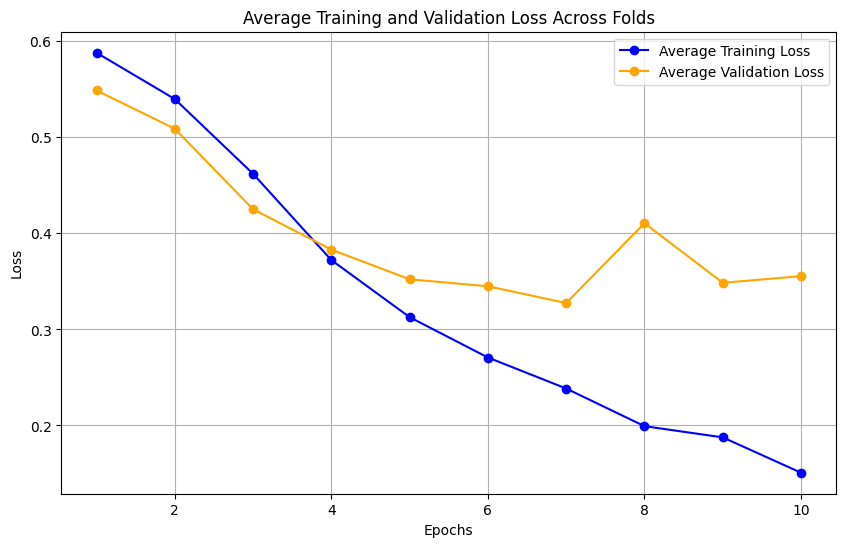

In [24]:
# DenseLayer or FinalClassifier
if isFinalClassifier:
    dense_layer_class = FinalClassifier
else:
    dense_layer_class = DenseLayer

# Run k-fold cross-validation   
results_df = cross_validate_model(
    dataset=full_dataset,
    model_class=GatedMultimodalUnit,
    dense_layer_class=dense_layer_class,
    criterion=criterion,
    text_dim=text_dim,
    audio_dim=audio_dim,
    video_dim=video_dim,
    output_dim=output_dim,
    num_epochs=num_epochs_cv,    
    num_folds=num_folds,
    train_batch_size=train_batch_size,
    val_batch_size=val_batch_size,
    learning_rate=learning_rate,
    output_file=f'results/gmu/GMU-CV_scores.csv'
)

In [25]:
df = pd.read_csv(f'results/gmu/GMU-CV_scores.csv')
df

,Metrics,Fold 1,Fold 2,Fold 3,Fold 4,Fold 5,Average
0,Loss,0.425599,0.484258,0.290266,0.286199,0.290838,0.355432
1,Accuracy,0.841509,0.777358,0.901887,0.898113,0.864151,0.856604
2,Precision,0.662651,0.526316,0.820513,0.888889,0.754717,0.730617
3,Recall,0.797101,0.781250,0.842105,0.645161,0.634921,0.740108
4,F1 Score,0.723684,0.628931,0.831169,0.747663,0.689655,0.724220
